In [1]:
import pandas as pd
%matplotlib inline
import tangos
import tangos.examples.mergers as mergers

import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
h = 0.6776942783267969
pd.set_option("display.max_rows", None, "display.max_columns", None)

from tangos_halo_module.halo_properties import velocity_angles, track_halo_property, get_timesteps, ID_to_sim_halo_snap, infall_final_n_particles, infall_final_coordinates, apocentric_distance, disruption_time, accretion_time, orbit_interpolation, infall_velocity, quenching_time, max_sSFR_time, max_mass_time 
from tangos_halo_module.path import get_file_path, get_halo_snap_num, read_file
from tangos_halo_module.halos import ID_to_tangos_halo, get_survivors, get_main_progenitor_branch, get_zombies, get_host, get_survivor_IDs, get_zombie_IDs, blockPrint, enablePrint, tangos_to_pynbody_halo

In [4]:
data = pd.read_csv('Data100.csv')
status = data['Status'].to_numpy()
ids = data['ID'].to_numpy()
t_disrupt = data['time_disruption'].to_numpy()
t_infall = data['time_infall'].to_numpy()

infall_vrad = abs(data['infall_radial_velocity'].to_numpy()/data['infall_relative_velocity'].to_numpy())
max_Mstar = data['max_stellarmass'].to_numpy()
log_max_Mstar = np.log10(max_Mstar)

t_quench = data['time_quench'].to_numpy()
# t_infall = np.array([accretion_time(ID=idx)[0] for idx in ids]) 
 
lookback_t_quench = 13.80-t_quench
lookback_t_disrupt = 13.80-t_disrupt
lookback_t_infall = 13.80-t_infall

phi_infall = data['infall_phi_z'].to_numpy()
phi_infall_deg = 180*phi_infall/np.pi
phi_infall_deg[phi_infall_deg>90]= 180-phi_infall_deg[phi_infall_deg>90]

phi_final = data['final_phi_z'].to_numpy()
phi_final_deg = 180*phi_final/np.pi
phi_final_deg[phi_final_deg>90]=180-phi_final_deg[phi_final_deg>90]

Delta_phi = phi_final_deg - phi_infall_deg

Mstar_infall = data['infall_mass'].to_numpy()
log_Mstar_infall = np.log10(Mstar_infall)

t_final = data['time_disruption'].to_numpy()
t_final[t_final==-1]=13.80 # For survivors
lookback_t_final = 13.80-t_final
Delta_t = t_final - t_infall
t_infall

array([ 8.198,  6.474,  8.609,  8.198,  3.888, 13.801,  5.868, 12.939,
       13.801, 10.767, 13.37 ,  6.474, 13.801,  4.75 ,  9.922, 13.37 ,
       12.508, 13.801,  7.767, 12.077,  4.75 , 13.37 ,  8.609,  9.491,
        6.474, 13.801, 10.353,  8.198,  0.767,  0.935,  0.935,  1.178,
        1.178,  1.178,  1.302,  1.302,  1.302,  1.302,  1.178,  1.178,
        1.545,  1.545,  1.545,  1.733,  1.733,  1.733,  1.733,  2.164,
        2.37 ,  2.164,  2.37 ,  2.37 ,  2.925,  3.289,  2.925,  3.457,
        3.457,  3.733,  3.888,  4.282,  3.733,  4.282,  5.181,  6.474,
        8.198,  9.06 , 13.585,  9.706, 13.801,  8.737,  7.444,  7.444,
       13.801,  8.414, 13.262,  7.04 , 13.262,  9.706,  8.414,  9.06 ,
        0.37 ,  0.477,  0.477,  0.642,  0.642,  0.642,  0.656,  0.767,
        0.767,  0.767,  0.935,  0.767,  0.935,  0.935,  0.935,  0.979,
        0.979,  0.935,  1.178,  1.178,  1.178,  1.178,  1.178,  1.949,
        1.626,  2.154,  3.565,  3.888,  3.888,  7.767,  9.06 , 11.323,
      

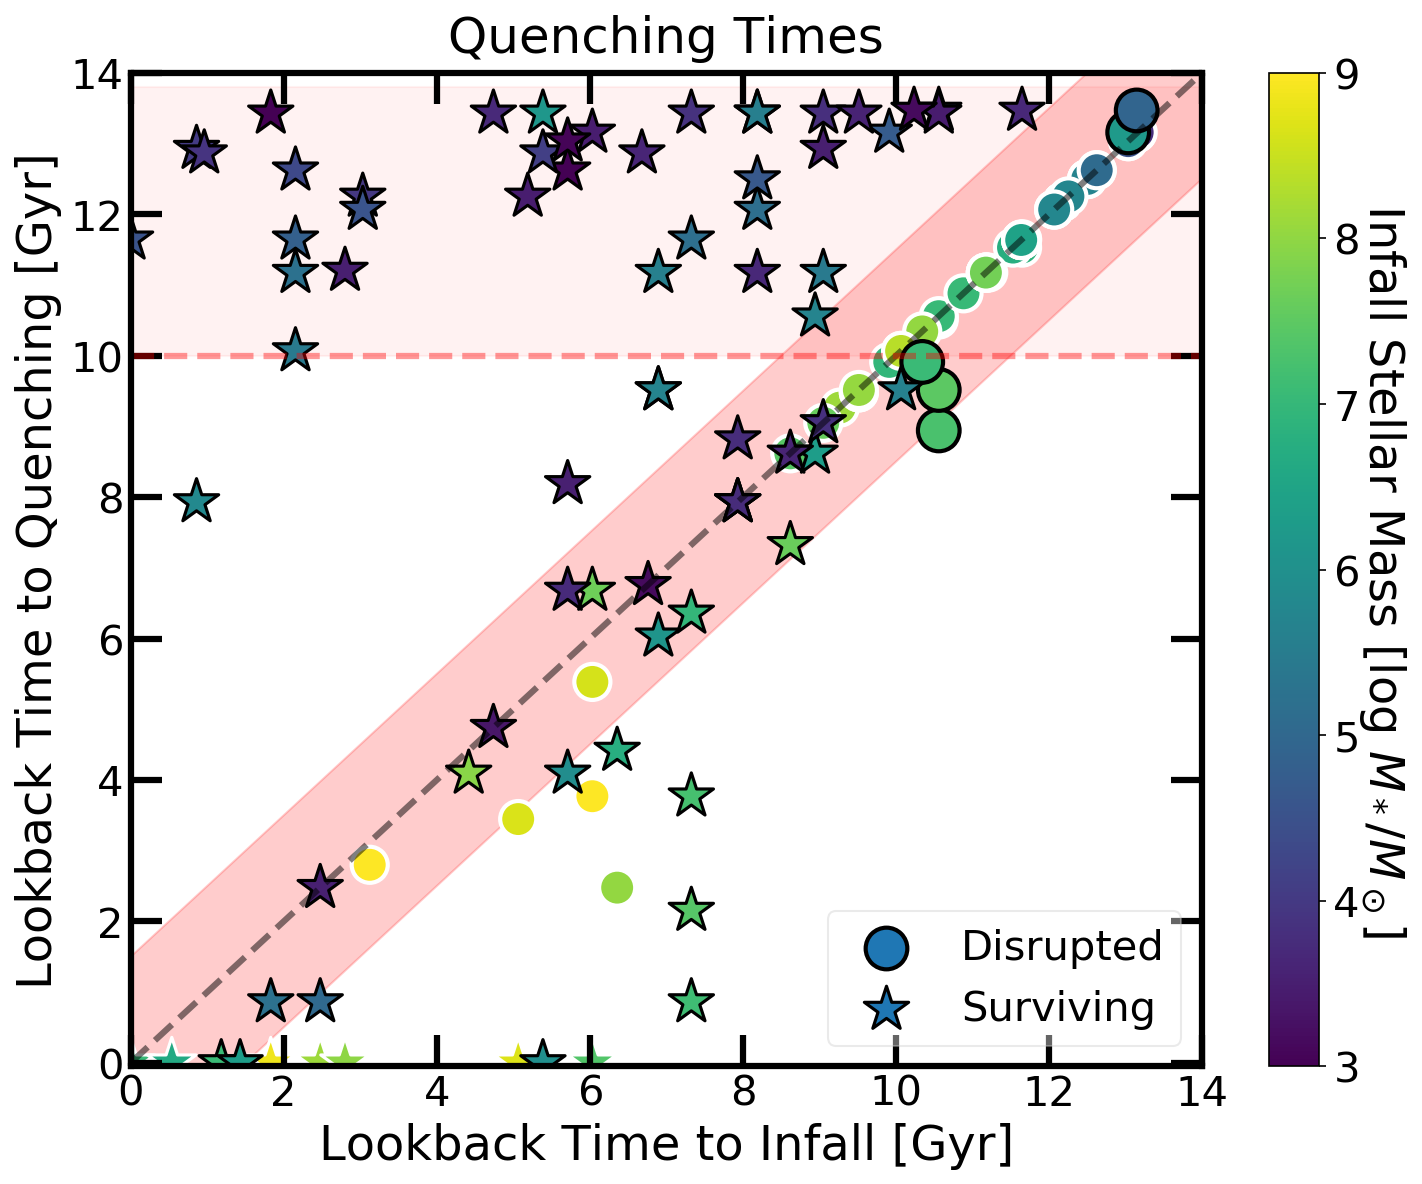

In [16]:
fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(10, 8))
# (ax1, ax2) = ax
fig.set_facecolor('w')
fig.set_dpi(150.0)
np.seterr(divide='ignore')

linx=np.linspace(0, 14, 100)
cm = plt.cm.get_cmap('viridis')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)

x=lookback_t_infall
y=lookback_t_quench
k=lookback_t_final
z=log_Mstar_infall
ax1.plot(linx, linx, lw=3, alpha=0.5, c='black', ls='--')
ax1.plot(linx, [10]*len(linx), lw=3, alpha=0.4, c='red', ls='--')
ax1.fill_between(linx, [10]*len(linx), [13.8]*len(linx), color='red', alpha=0.05)
ax1.fill_between(linx, linx-1.5, linx+1.5, color='red', alpha=0.2)

# Zombies
ax1.scatter(x[(status=='Zombie') & (y>13.8)], k[(status=='Zombie') & (y>13.8)], marker='o', 
            edgecolor='w', c=z[(status=='Zombie') & (y>13.8)], lw=2, s=300, cmap=cm, vmin=3, vmax=9) 
ax1.scatter(x[(status=='Zombie') & (y<13.8)], y[(status=='Zombie') & (y<13.8)], marker='o', 
            edgecolor='k', c=z[(status=='Zombie') & (y<13.8)], lw=2, s=400, cmap=cm, vmin=3, vmax=9, 
            label='Disrupted')
# Survivors
im1 = ax1.scatter(x[(status=='Survivor') & (y>13.8)], k[(status=='Survivor') & (y>13.8)], marker='*', edgecolor='w',
                  c=z[(status=='Survivor') & (y>13.8)], lw=1.5, s=600, cmap=cm, vmin=3, vmax=9)
im1 = ax1.scatter(x[status=='Survivor'], y[status=='Survivor'], marker='*', edgecolor='k', 
                  c=z[status=='Survivor'], lw=1.5, s=500, cmap=cm, vmin=3, vmax=9, 
                  label='Surviving') 
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label('Infall Stellar Mass [log $M_*/M_\odot$]', rotation=270, fontsize=23, labelpad=23)
cbar1.ax.tick_params(labelsize=20)
ax1.set_xlim(0, 14)
ax1.set_ylim(-0.05, 14)
ax1.legend(loc='lower right', fontsize=20, frameon=True, framealpha=0.4)
ax1.tick_params(which='major', length=15, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Quenching Times', fontsize=24, pad=10)
ax1.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=23)
ax1.set_ylabel('Lookback Time to Quenching [Gyr]', fontsize=23)

fig.tight_layout()

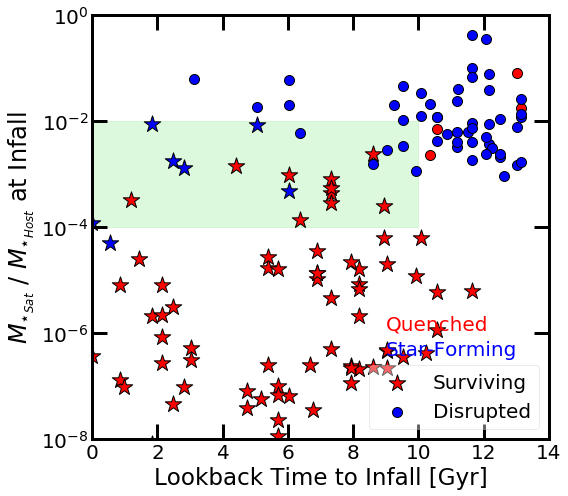

In [17]:
fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(8, 7))
# (ax1, ax2) = ax
fig.set_facecolor('w')
# fig.set_dpi(150.0)
np.seterr(divide='ignore')

linx=np.linspace(0, 10, 100)
cm = plt.cm.get_cmap('viridis')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)
# fig.set_dpi(150)
x = lookback_t_infall
y = data['infall_mass_ratio'].to_numpy()

ax1.fill_between(linx, [1e-2]*len(linx), [1e-4]*len(linx), alpha=0.3, color='lightgreen')
# the scatter plot:
ax1.scatter(x[(status=='Survivor')&(t_quench>=0)], y[(status=='Survivor')&(t_quench>=0)], s=300, 
                   color='red', marker='*', edgecolors="black", linewidth=1, alpha=1, label = 'Surviving')
ax1.scatter(x[(status=='Survivor')&(t_quench<0)], y[(status=='Survivor')&(t_quench<0)], s=300,  
                   color='blue', marker='*', edgecolors="black", linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench>=0)], y[(status=='Zombie')&(t_quench>=0)], s=100, 
                   color='red', edgecolors='black', facecolors='red', linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench<0)], y[(status=='Zombie')&(t_quench<0)], s=100, 
                   color='blue', edgecolors='black', facecolors='blue', linewidth=1, alpha=1, label = 'Disrupted')
ax1.text(9, 1.5e-6, 'Quenched', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='red')
ax1.text(9, 0.5e-6, 'Star-Forming', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='blue')
ax1.set_xlim(0, 14)
ax1.set_ylim(1e-8 , 1e0)
ax1.set_yscale('log')
ax1.legend(loc='lower right', fontsize=20, frameon=True, framealpha=0.4)
ax1.tick_params(which='major', length=15, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
# ax1.set_title('Quenching Times', fontsize=24, pad=10)
ax1.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=23)
ax1.set_ylabel('$M_{\star_{Sat}}$ / $M_{\star_{Host}}$ at Infall', fontsize=24)

fig.tight_layout()

In [5]:
def max_mass_time(ID=0, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0, category='stars', resolution=1000):
    '''
    input params: 
        simulation: h148, h229, h242, h329: string
        status: 'Zombie', 'Survivor': string
        tangos_halo: 0 or a valid Tangos halo object
        halo_id: halo id: 0 or string or numeric
        snap_num: 0 or 4 digit simulation snapshot number: string
        category: 'stars' or 'dm' or 'total': string
    output params:
        maximum stellar mass: the maximum stellar mass of a dwarf before disruption
            [units: Msol]
        time of maximum stellar mass: the earliest time before disruption when a dwarf reaches its maximum stellar mass
            [units: Gyr since start of simulation]
    '''
    if ID != 0:
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
    #Host
    path = get_file_path(tangos_halo=0, simulation=simulation, status='Host', halo_id='1', snap_num='4096', resolution=resolution)
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostMstar = fh['M_star_|_Msol'][:]
        hostMvir = fh['Mvir_|_Msol'][:]
        hostMgas = fh['M_gas_|_Msol'][:]
    #Satellite
    path = get_file_path(tangos_halo=tangos_halo, simulation=simulation, status=status, halo_id=halo_id, snap_num=snap_num, resolution=resolution)
    with h5py.File(path, 'r') as f:
        satMstar = f['M_star_|_Msol'][:]
        satMvir = f['Mvir_|_Msol'][:]
        satMgas = f['M_gas_|_Msol'][:]
    total_mass=satMstar+satMvir+satMgas    
    
    if category=='stars':
        max_satM = max(satMstar[satMstar != hostMstar])
        max_satM_time = min(t_Gyr[satMstar==max_satM])
    elif category=='dm':
        max_satM = max(satMvir[satMvir != hostMvir])
        max_satM_time = min(t_Gyr[satMvir==max_satM])
    elif category=='total':
        max_satM = max(total_mass[satMstar != hostMstar])
        max_satM_time = min(t_Gyr[total_mass==max_satM])
    elif category=='ratio':
        ratio = satMstar/total_mass
        ratio[total_mass==0]=0
        max_satM = max(ratio[satMstar != hostMstar])
        max_satM_time = min(t_Gyr[ratio==max_satM])
    else:
        raise ValueError('A very specific bad thing happened. Try category= "stars" or "dm".') 
    
    return max_satM, max_satM_time
np.array([max_mass_time(ID=idx, category='ratio', resolution=100)[0] for idx in ids])

/home/pathakde/anaconda3/envs/conda-env-py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


array([1.05616208e-02, 1.13372570e-04, 2.33511647e-03, 1.13135420e-02,
       1.32111814e-02, 1.39760323e-03, 7.71306924e-04, 1.95007399e-02,
       8.14611668e-02, 9.37584927e-03, 1.85834094e-02, 2.52094554e-02,
       5.86481307e-03, 2.53357481e-02, 3.08912728e-02, 8.63862942e-05,
       4.79718070e-05, 1.78479344e-04, 6.81858046e-03, 1.17360233e-02,
       2.05366109e-03, 5.27897496e-06, 1.72651808e-03, 1.33138367e-03,
       2.84390764e-02, 7.46861336e-05, 7.78729359e-05, 5.65763086e-04,
       6.47913306e-05, 1.02878691e-03, 8.76966862e-05, 1.09348449e-03,
       2.62618609e-03, 6.15850971e-04, 3.91700023e-03, 3.40300606e-04,
       1.51987416e-04, 2.82681086e-03, 1.41281253e-04, 9.00192098e-04,
       2.88581137e-02, 8.06161971e-03, 1.26458890e-03, 4.23272235e-03,
       1.06860632e-03, 7.40606664e-04, 5.95059617e-04, 2.10794649e-02,
       9.72995664e-03, 1.45815079e-02, 4.97285560e-03, 4.89920534e-03,
       3.27621343e-03, 4.04488010e-03, 2.00284179e-02, 2.34822024e-03,
      

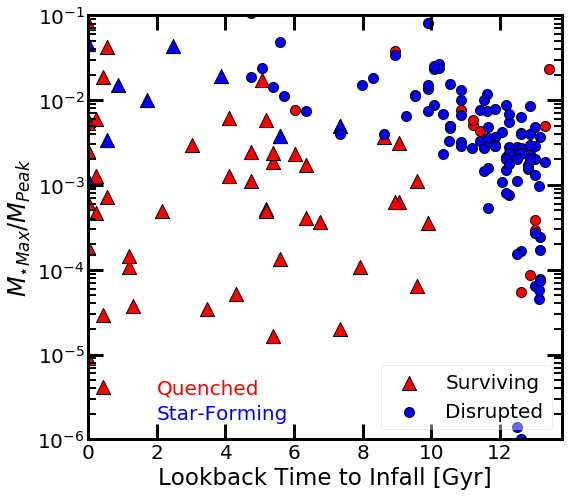

In [6]:
#Ferah's figure

fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(8, 7))
# (ax1, ax2) = ax
fig.set_facecolor('w')
# fig.set_dpi(150.0)
np.seterr(divide='ignore')

linx=np.linspace(0, 14, 100)
cm = plt.cm.get_cmap('viridis')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
# plt.setp(ax2.spines.values(), linewidth=3)

Mpeak=np.array([max_mass_time(ID=idx, category='total', resolution=100)[0] for idx in ids])
x = lookback_t_infall
y = (max_Mstar/Mpeak)

# the scatter plot:
ax1.scatter(x[(status=='Survivor')&(t_quench>=0)], y[(status=='Survivor')&(t_quench>=0)], s=200, 
                   color='red', marker='^', edgecolors="black", linewidth=1, alpha=1, label = 'Surviving')
ax1.scatter(x[(status=='Survivor')&(t_quench<0)], y[(status=='Survivor')&(t_quench<0)], s=200,  
                   color='blue', marker='^', edgecolors="black", linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench>=0)], y[(status=='Zombie')&(t_quench>=0)], s=100, 
                   color='red', edgecolors='black', facecolors='red', linewidth=1, alpha=1)
ax1.scatter(x[(status=='Zombie')&(t_quench<0)], y[(status=='Zombie')&(t_quench<0)], s=100, 
                   color='blue', edgecolors='black', facecolors='blue', linewidth=1, alpha=1, label = 'Disrupted')
ax1.text(2, 4e-6, 'Quenched', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='red')
ax1.text(2, 2e-6, 'Star-Forming', horizontalalignment='left', verticalalignment='center',
         fontsize=20, color='blue')
ax1.set_xlim(0, 13.8)
ax1.set_ylim(1e-6 , 1e-1)
ax1.set_yscale('log')
ax1.legend(loc='lower right', fontsize=20, frameon=True, framealpha=0.4)
ax1.tick_params(which='major', length=15, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
# ax1.set_title('Quenching Times', fontsize=24, pad=10)
ax1.set_xlabel('Lookback Time to Infall [Gyr]', fontsize=23)
ax1.set_ylabel('$M_{\star Max}/M_{Peak}$', fontsize=24)

fig.tight_layout()

Text(0, 0.5, 'b [kpc]')

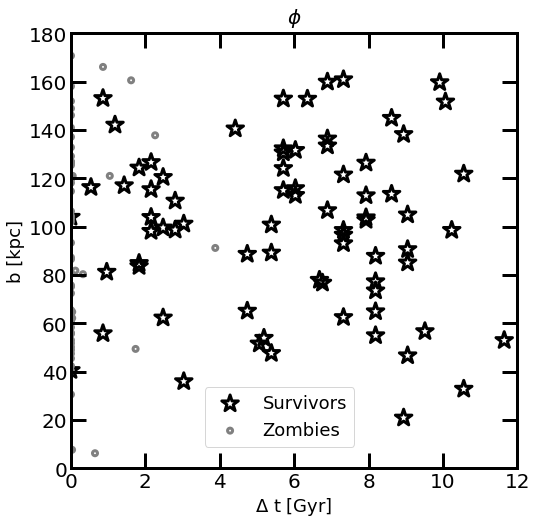

In [27]:
t_infall = data['time_infall'].to_numpy()
# print(t_infall)
status = data['Status'].to_numpy()
# print(status)
phi_infall = data['infall_phi_z'].to_numpy()
phi_infall_deg = 180*phi_infall/np.pi
t_final = data['time_disruption'].to_numpy()
t_final[t_final==-1]=13.80 # For survivors
# print(t_final)
Delta_t = t_final - t_infall
# print(Delta_t)

fig, ax1 = plt.subplots(1, 1, sharex='none', sharey='none', figsize=(8, 8))
fig.set_facecolor('w')
np.seterr(divide='ignore')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)

# Survivors
ax1.scatter(Delta_t[status=='Survivor'], phi_infall_deg[status=='Survivor'], marker='*', edgecolor='k', facecolor='none', lw=3, s=300, label='Survivors') 
ax1.scatter(Delta_t[status=='Zombie'], phi_infall_deg[status=='Zombie'], marker='.', edgecolor='grey', facecolor='none', lw=3, s=100, label='Zombies') 
# ax1.set_yscale('log')
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 180)
ax1.legend(loc=[0.3, 0.05], fontsize=18, frameon=True)
ax1.tick_params(which='major', length=15, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('$\phi$', fontsize=20, pad=10)
ax1.set_xlabel('$\Delta$ t [Gyr]', fontsize=18)
ax1.set_ylabel('b [kpc]', fontsize=18)

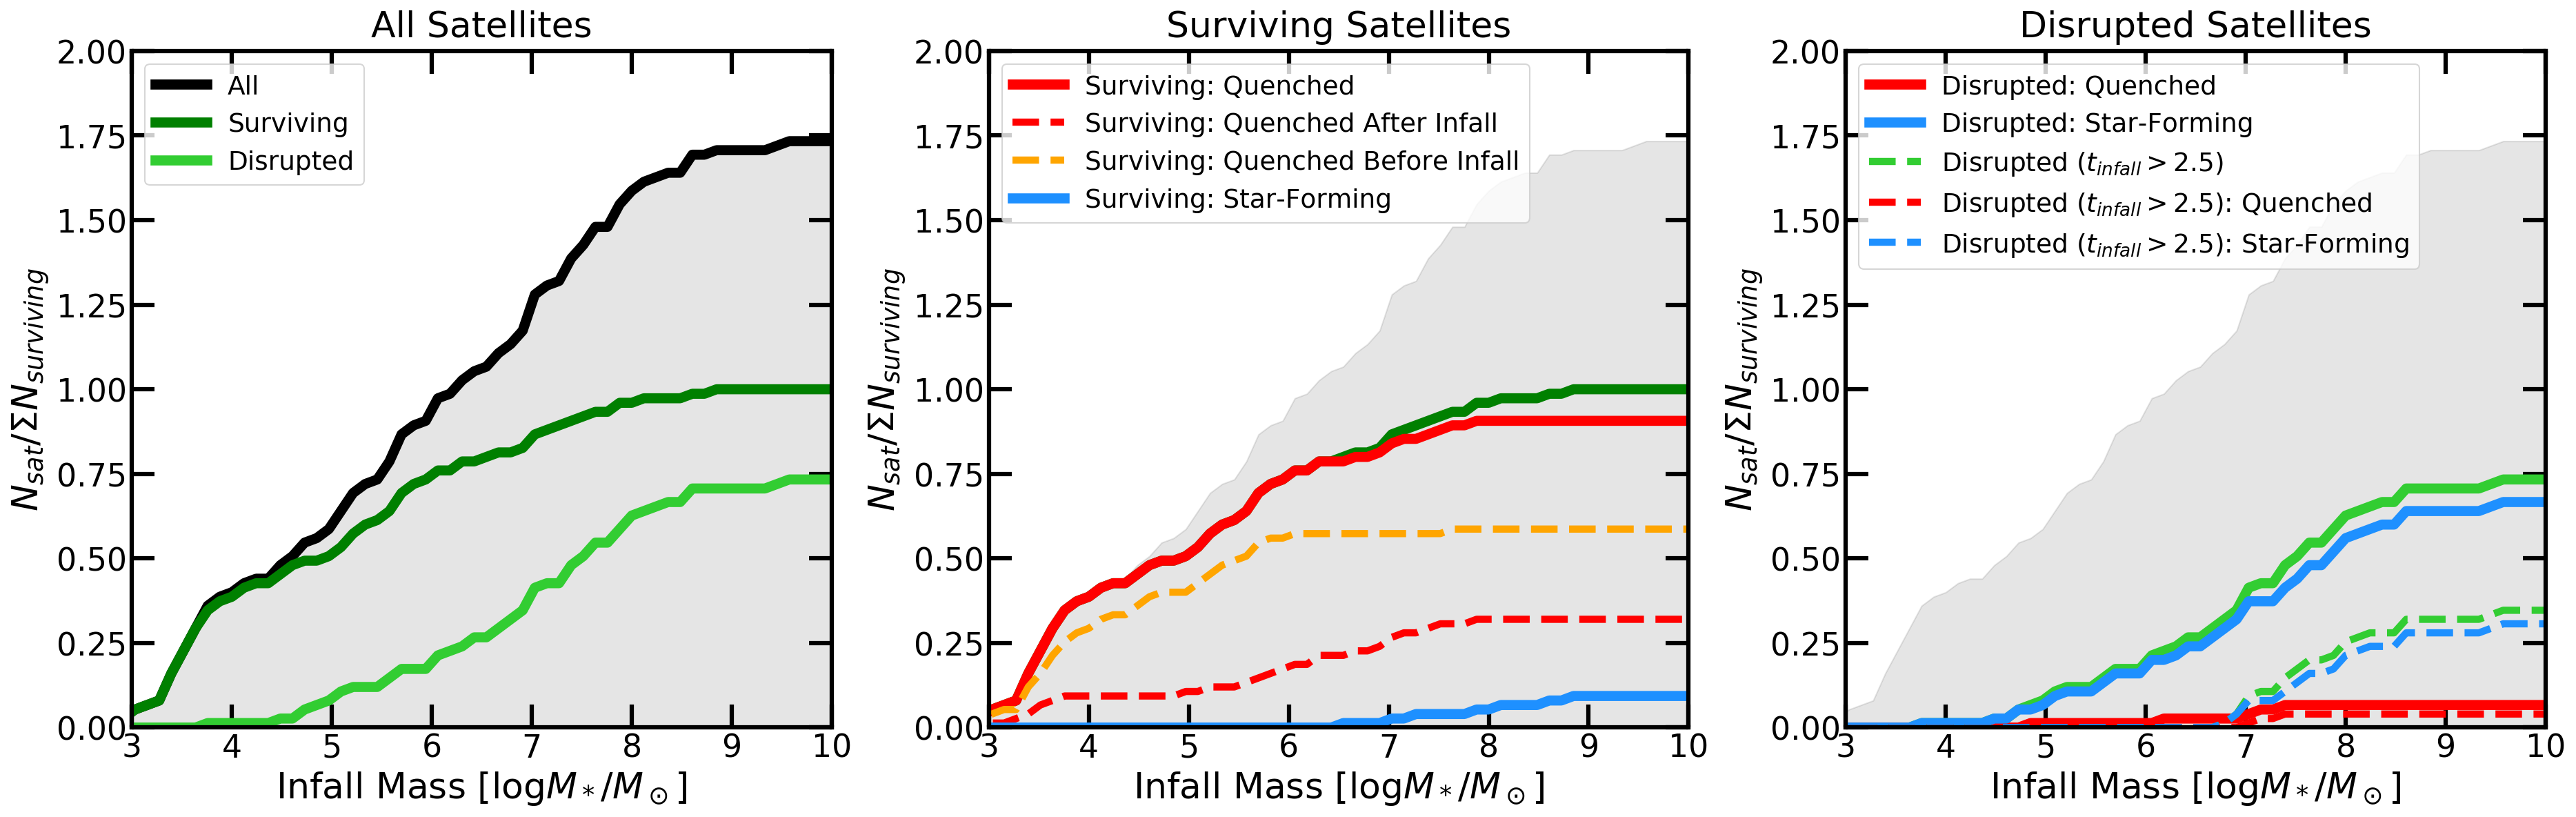

In [29]:
status = data['Status'].to_numpy()
simulation = data['Simulation'].to_numpy()
M_infall = np.log10(data['infall_mass'].to_numpy())
t_quench = data['time_quench'].to_numpy()
t_infall = data['time_infall'].to_numpy()

norm = len(status[status=='Survivor'])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='none', sharey='none', figsize=(25, 8))
fig.set_facecolor('w')
np.seterr(divide='ignore')
fig.set_dpi(150)
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
plt.setp(ax3.spines.values(), linewidth=3)
linx=np.linspace(0, 12, 100)
# Survivors


A, B = np.histogram(M_infall, linx)
ax1.fill_between(B[:-1], np.cumsum(A)/norm, color='black', alpha=0.1)
ax1.plot(B[:-1], np.cumsum(A)/norm, color='black', lw=7, label='All')
A, B = np.histogram(M_infall[status=='Survivor'], linx)
ax1.plot(B[:-1], np.cumsum(A)/norm, color='green',  lw=7, label='Surviving')
A, B = np.histogram(M_infall[status=='Zombie'], linx)
ax1.plot(B[:-1], np.cumsum(A)/norm, color='limegreen',  lw=7, label='Disrupted')
ax1.set_xlim(3, 10)
ax1.set_ylim(0, 2)
ax1.legend(loc='upper left', fontsize=18, frameon=True)
ax1.tick_params(which='major', length=16, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=22, bottom=True, top=True, left=True, right=True)
ax1.set_title('All Satellites', fontsize=25, pad=10)
ax1.set_xlabel('Infall Mass [$\log M_*/M_\odot$]', fontsize=25)
ax1.set_ylabel('$N_{sat}/\Sigma N_{surviving}$', fontsize=25)


A, B = np.histogram(M_infall, linx)
ax2.fill_between(B[:-1], np.cumsum(A)/norm, color='black', alpha=0.1)
A, B = np.histogram(M_infall[status=='Survivor'], linx)
ax2.plot(B[:-1], np.cumsum(A)/norm, color='green',  lw=7)
A, B = np.histogram(M_infall[(status=='Survivor') & (t_quench>0)], linx)
ax2.plot(B[:-1], np.cumsum(A)/norm, color='red',  lw=7, label='Surviving: Quenched')

A, B = np.histogram(M_infall[(status=='Survivor') & (t_quench>=t_infall)], linx)
ax2.plot(B[:-1], np.cumsum(A)/norm, color='red',  ls='--', lw=5, label='Surviving: Quenched After Infall')
A, B = np.histogram(M_infall[(status=='Survivor') & (t_quench>0) & (t_quench<t_infall)], linx)
ax2.plot(B[:-1], np.cumsum(A)/norm, color='orange',  ls='--', lw=5, label='Surviving: Quenched Before Infall')

A, B = np.histogram(M_infall[(status=='Survivor') & (t_quench<=0)], linx)
ax2.plot(B[:-1], np.cumsum(A)/norm, color='dodgerblue',  lw=7, label='Surviving: Star-Forming')
ax2.set_xlim(3, 10)
ax2.set_ylim(0, 2)
ax2.legend(loc='upper left', fontsize=18, frameon=True)
ax2.tick_params(which='major', length=16, width=3, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=22, bottom=True, top=True, left=True, right=True)
ax2.set_title('Surviving Satellites', fontsize=25, pad=10)
ax2.set_xlabel('Infall Mass [$\log M_*/M_\odot$]', fontsize=25)
ax2.set_ylabel('$N_{sat}/\Sigma N_{surviving}$', fontsize=25)

A, B = np.histogram(M_infall, linx)
ax3.fill_between(B[:-1], np.cumsum(A)/norm, color='black', alpha=0.1)
A, B = np.histogram(M_infall[status=='Zombie'], linx)
ax3.plot(B[:-1], np.cumsum(A)/norm, color='limegreen',  lw=7)
A, B = np.histogram(M_infall[(status=='Zombie') & (t_quench>0)], linx)
ax3.plot(B[:-1], np.cumsum(A)/norm, color='red',  lw=7, label='Disrupted: Quenched')
A, B = np.histogram(M_infall[(status=='Zombie') & (t_quench<=0)], linx)
ax3.plot(B[:-1], np.cumsum(A)/norm, color='dodgerblue',  lw=7, label='Disrupted: Star-Forming')
A, B = np.histogram(M_infall[(status=='Zombie') & (t_infall>=2.5)], linx)
ax3.plot(B[:-1], np.cumsum(A)/norm, color='limegreen',  lw=5, ls='--', label='Disrupted ($t_{infall} > 2.5$)')
A, B = np.histogram(M_infall[(status=='Zombie') & (t_quench>0) & (t_infall>=2.5)], linx)
ax3.plot(B[:-1], np.cumsum(A)/norm, color='red',  lw=5, ls='--', label='Disrupted ($t_{infall} > 2.5$): Quenched')
A, B = np.histogram(M_infall[(status=='Zombie') & (t_quench<=0) & (t_infall>=2.5)], linx)
ax3.plot(B[:-1], np.cumsum(A)/norm, color='dodgerblue',  lw=5, ls='--', label='Disrupted ($t_{infall} > 2.5$): Star-Forming')

ax3.set_xlim(3, 10)
ax3.set_ylim(0, 2)
ax3.legend(loc='upper left', fontsize=18, frameon=True)
ax3.tick_params(which='major', length=16, width=3, labelsize=15)
ax3.tick_params(which='minor', length=8, width=2, labelsize=15)
ax3.tick_params(direction='in', which='both', labelsize=22, bottom=True, top=True, left=True, right=True)
ax3.set_title('Disrupted Satellites', fontsize=25, pad=10)
ax3.set_xlabel('Infall Mass [$\log M_*/M_\odot$]', fontsize=25)
ax3.set_ylabel('$N_{sat}/\Sigma N_{surviving}$', fontsize=25)

fig.tight_layout()

In [ ]:
data = pd.read_csv('Data100.csv')
simulation = data['Simulation'].to_numpy()
myIDs = data['ID'].to_numpy()[(simulation!='h229') & (simulation!='h242')]

t_infall = data['time_infall'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(t_infall)
status = data['Status'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(status)
d_impact = M_infall = np.log10(data['infall_mass'].to_numpy())[(simulation!='h229') & (simulation!='h242')]
#data['impact_parameter_kpc'].to_numpy()
# print(d_impact)
t_final = data['time_disruption'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
t_final[t_final==-1]=13.80 # For survivors
# print(t_final)
Delta_t = t_final - t_infall
# print(Delta_t)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(16, 7))
fig.set_facecolor('w')
# fig.set_dpi(150)
np.seterr(divide='ignore')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)

# Survivors
ax1.scatter(Delta_t[status=='Zombie'], d_impact[status=='Zombie'], marker='.', edgecolor='grey', facecolor='none', lw=4, s=400, label='Disrupted') 
ax1.scatter(Delta_t[status=='Survivor'], d_impact[status=='Survivor'], marker='*', edgecolor='k', facecolor='none', lw=3, s=300, label='Surviving') 
# ax1.set_yscale('log')
ax1.set_xlim(0, 12)
ax1.set_ylim(2, 10)
ax1.legend(loc='upper right', fontsize=18, frameon=True)
ax1.tick_params(which='major', length=16, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Near-Mint Sandra & Elena', fontsize=20, pad=10)
ax1.set_xlabel('$\Delta$ t [Gyr]', fontsize=20)
ax1.set_ylabel('$\log M_*$ at Infall [$\log M_\odot$]', fontsize=20)


data = pd.read_csv('Mint_Data/Data100.csv')
simulation = data['Simulation'].to_numpy()
myIDs = data['ID'].to_numpy()[(simulation!='h229') & (simulation!='h242')]

t_infall = data['time_infall'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(t_infall)
status = data['Status'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(status)
d_impact = M_infall = np.log10(data['infall_mass'].to_numpy())[(simulation!='h229') & (simulation!='h242')]
# print(d_impact)
t_final = data['near_mint_time_disruption'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
t_final[t_final==-1]=13.80 # For survivors
# print(t_final)
Delta_t = t_final - t_infall
# print(Delta_t)


# Survivors
ax2.scatter(Delta_t[status=='Zombie'], d_impact[status=='Zombie'], marker='.', edgecolor='grey', facecolor='none', lw=4, s=400, label='Disrupted') 
ax2.scatter(Delta_t[status=='Survivor'], d_impact[status=='Survivor'], marker='*', edgecolor='k', facecolor='none', lw=3, s=300, label='Surviving') 
# ax2.set_yscale('log')
ax2.set_xlim(0, 12)
ax2.set_ylim(2, 10)
# ax2.legend(loc='upper right', fontsize=18, frameon=True)
ax2.tick_params(which='major', length=16, width=3, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('Mint Sandra & Elena', fontsize=20, pad=10)
ax2.set_xlabel('$\Delta$ t [Gyr]', fontsize=20)
ax2.set_ylabel('$\log M_*$ at Infall [$\log M_\odot$]', fontsize=20)

Text(0, 0.5, '$\\log M_*$ at Infall [$\\log M_\\odot$]')

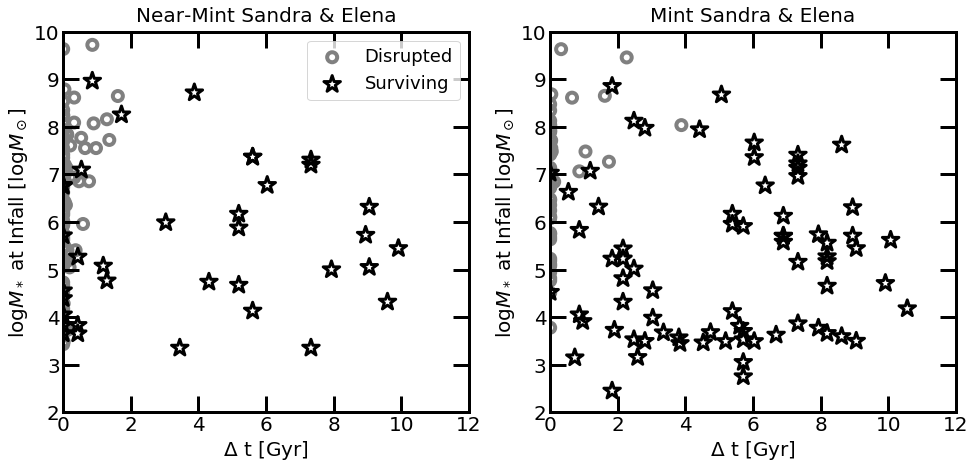

In [5]:
data = pd.read_csv('Data100.csv')
simulation = data['Simulation'].to_numpy()
myIDs = data['ID'].to_numpy()[(simulation!='h229') & (simulation!='h242')]

t_infall = data['time_infall'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(t_infall)
status = data['Status'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(status)
d_impact = M_infall = np.log10(data['infall_mass'].to_numpy())[(simulation!='h229') & (simulation!='h242')]
#data['impact_parameter_kpc'].to_numpy()
# print(d_impact)
t_final = data['time_disruption'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
t_final[t_final==-1]=13.80 # For survivors
# print(t_final)
Delta_t = t_final - t_infall
# print(Delta_t)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(16, 7))
fig.set_facecolor('w')
# fig.set_dpi(150)
np.seterr(divide='ignore')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)

# Survivors
ax1.scatter(Delta_t[status=='Zombie'], d_impact[status=='Zombie'], marker='.', edgecolor='grey', facecolor='none', lw=4, s=400, label='Disrupted') 
ax1.scatter(Delta_t[status=='Survivor'], d_impact[status=='Survivor'], marker='*', edgecolor='k', facecolor='none', lw=3, s=300, label='Surviving') 
# ax1.set_yscale('log')
ax1.set_xlim(0, 12)
ax1.set_ylim(2, 10)
ax1.legend(loc='upper right', fontsize=18, frameon=True)
ax1.tick_params(which='major', length=16, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Near-Mint Sandra & Elena', fontsize=20, pad=10)
ax1.set_xlabel('$\Delta$ t [Gyr]', fontsize=20)
ax1.set_ylabel('$\log M_*$ at Infall [$\log M_\odot$]', fontsize=20)


data = pd.read_csv('Mint_Data/Data100.csv')
simulation = data['Simulation'].to_numpy()
myIDs = data['ID'].to_numpy()[(simulation!='h229') & (simulation!='h242')]

t_infall = data['time_infall'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(t_infall)
status = data['Status'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(status)
d_impact = M_infall = np.log10(data['infall_mass'].to_numpy())[(simulation!='h229') & (simulation!='h242')]
# print(d_impact)
t_final = data['near_mint_time_disruption'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
t_final[t_final==-1]=13.80 # For survivors
# print(t_final)
Delta_t = t_final - t_infall
# print(Delta_t)


# Survivors
ax2.scatter(Delta_t[status=='Zombie'], d_impact[status=='Zombie'], marker='.', edgecolor='grey', facecolor='none', lw=4, s=400, label='Disrupted') 
ax2.scatter(Delta_t[status=='Survivor'], d_impact[status=='Survivor'], marker='*', edgecolor='k', facecolor='none', lw=3, s=300, label='Surviving') 
# ax2.set_yscale('log')
ax2.set_xlim(0, 12)
ax2.set_ylim(2, 10)
# ax2.legend(loc='upper right', fontsize=18, frameon=True)
ax2.tick_params(which='major', length=16, width=3, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('Mint Sandra & Elena', fontsize=20, pad=10)
ax2.set_xlabel('$\Delta$ t [Gyr]', fontsize=20)
ax2.set_ylabel('$\log M_*$ at Infall [$\log M_\odot$]', fontsize=20)

Text(0, 0.5, '$\\log M_{vir}$ at Infall [$\\log M_\\odot$]')

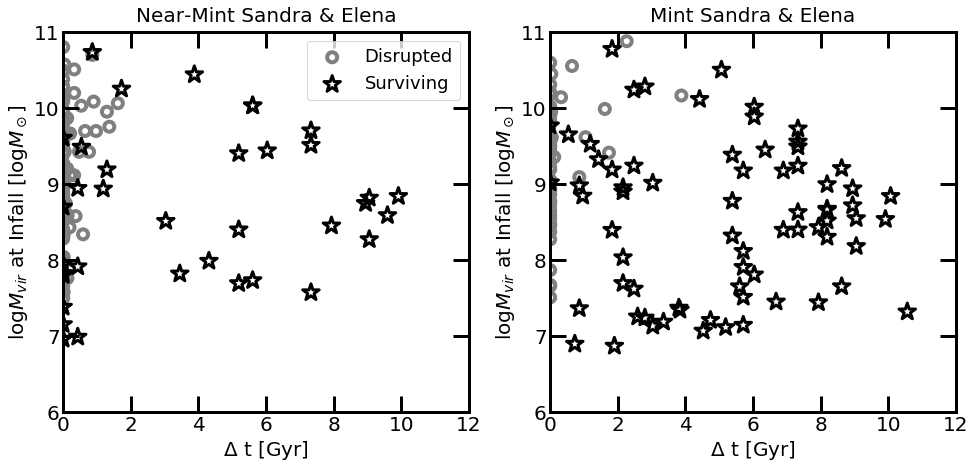

In [6]:
data = pd.read_csv('Data100.csv')
simulation = data['Simulation'].to_numpy()
myIDs = data['ID'].to_numpy()[(simulation!='h229') & (simulation!='h242')]

t_infall = data['time_infall'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(t_infall)
status = data['Status'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(status)
d_impact = M_infall = np.log10(data['infall_virial_mass'].to_numpy())[(simulation!='h229') & (simulation!='h242')]
#data['impact_parameter_kpc'].to_numpy()
# print(d_impact)
t_final = data['time_disruption'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
t_final[t_final==-1]=13.80 # For survivors
# print(t_final)
Delta_t = t_final - t_infall
# print(Delta_t)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='none', sharey='none', figsize=(16, 7))
fig.set_facecolor('w')
# fig.set_dpi(150)
np.seterr(divide='ignore')
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)

# Survivors
ax1.scatter(Delta_t[status=='Zombie'], d_impact[status=='Zombie'], marker='.', edgecolor='grey', facecolor='none', lw=4, s=400, label='Disrupted') 
ax1.scatter(Delta_t[status=='Survivor'], d_impact[status=='Survivor'], marker='*', edgecolor='k', facecolor='none', lw=3, s=300, label='Surviving') 
# ax1.set_yscale('log')
ax1.set_xlim(0, 12)
ax1.set_ylim(6, 11)
ax1.legend(loc='upper right', fontsize=18, frameon=True)
ax1.tick_params(which='major', length=16, width=3, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('Near-Mint Sandra & Elena', fontsize=20, pad=10)
ax1.set_xlabel('$\Delta$ t [Gyr]', fontsize=20)
ax1.set_ylabel('$\log M_{vir}$ at Infall [$\log M_\odot$]', fontsize=20)


data = pd.read_csv('Mint_Data/Data100.csv')
simulation = data['Simulation'].to_numpy()
myIDs = data['ID'].to_numpy()[(simulation!='h229') & (simulation!='h242')]

t_infall = data['time_infall'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(t_infall)
status = data['Status'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
# print(status)
d_impact = M_infall = np.log10(data['infall_virial_mass'].to_numpy())[(simulation!='h229') & (simulation!='h242')]
# print(d_impact)
t_final = data['near_mint_time_disruption'].to_numpy()[(simulation!='h229') & (simulation!='h242')]
t_final[t_final==-1]=13.80 # For survivors
# print(t_final)
Delta_t = t_final - t_infall
# print(Delta_t)


# Survivors
ax2.scatter(Delta_t[status=='Zombie'], d_impact[status=='Zombie'], marker='.', edgecolor='grey', facecolor='none', lw=4, s=400, label='Disrupted') 
ax2.scatter(Delta_t[status=='Survivor'], d_impact[status=='Survivor'], marker='*', edgecolor='k', facecolor='none', lw=3, s=300, label='Surviving') 
# ax2.set_yscale('log')
ax2.set_xlim(0, 12)
ax2.set_ylim(6, 11)
# ax2.legend(loc='upper right', fontsize=18, frameon=True)
ax2.tick_params(which='major', length=16, width=3, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('Mint Sandra & Elena', fontsize=20, pad=10)
ax2.set_xlabel('$\Delta$ t [Gyr]', fontsize=20)
ax2.set_ylabel('$\log M_{vir}$ at Infall [$\log M_\odot$]', fontsize=20)

Text(0, 0.5, 'Distance from Host [kpc]')

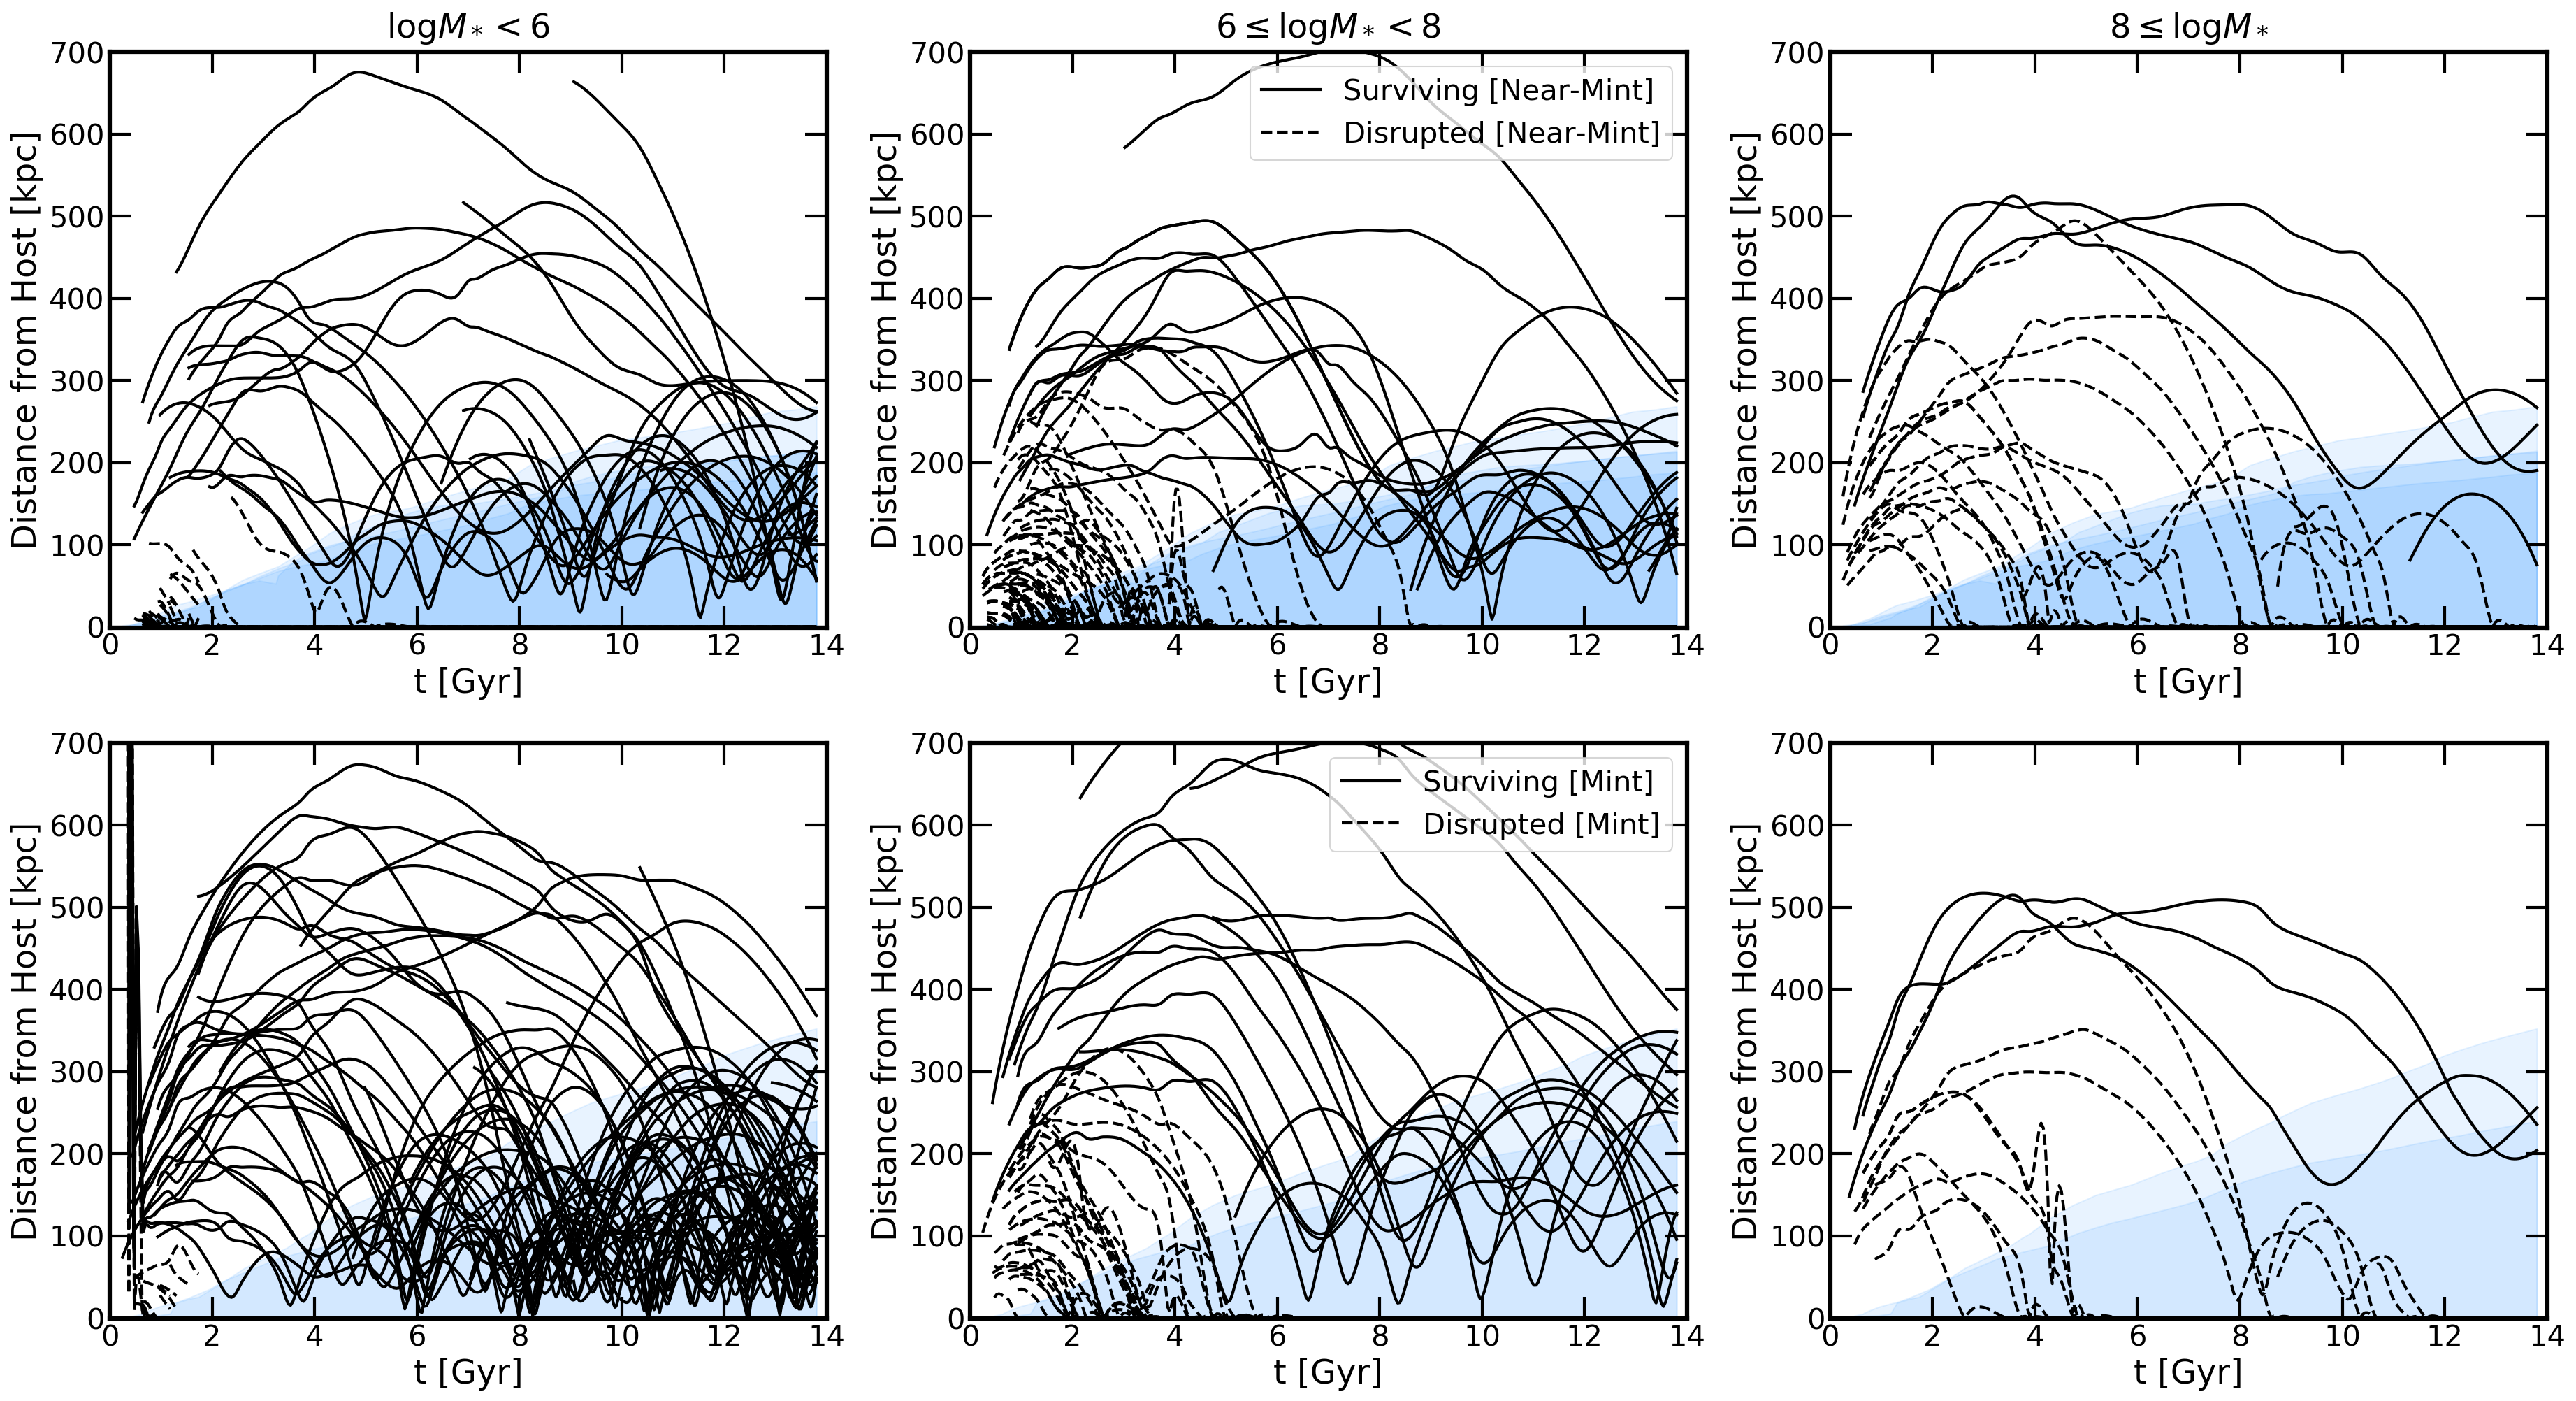

In [15]:
np.seterr(divide='ignore', invalid='ignore')


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(30, 16))
fig.set_facecolor('w')
fig.set_dpi(150)
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
plt.setp(ax3.spines.values(), linewidth=3)
plt.setp(ax4.spines.values(), linewidth=3)
plt.setp(ax5.spines.values(), linewidth=3)
plt.setp(ax6.spines.values(), linewidth=3)

for sim in ['h148', 'h229', 'h242', 'h329']:
    #Near Mint 100 ptcls
    path = get_file_path(tangos_halo=0, simulation=sim, status='Host', halo_id='1', snap_num='4096', resolution=100)
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostRvir = fh['Rvir_|_kpc'][:]
    ax1.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax2.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax3.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
for sim in ['h148', 'h329']:
    #Mint 100 ptcls
    path = get_file_path(tangos_halo=0, simulation=sim, status='Host', halo_id='1', snap_num='4096', resolution='Mint')
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostRvir = fh['Rvir_|_kpc'][:]
    ax4.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax5.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax6.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)

    
# -------------------------- Near Mint -------------------------
data = pd.read_csv('Data100.csv')
status = data['Status'].to_numpy()
ids = data['ID'].to_numpy()
infall_Mstar = data['infall_mass'].to_numpy()
t_infall = data['time_infall'].to_numpy()
t_disrupt = data['time_disruption'].to_numpy()
count=0    
for idx in ids[(status=='Survivor')]:
    k, (t, x, y, z, R) = orbit_interpolation(ID=idx, resolution=100)
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)   
    R = (x**2 + y**2 + z**2)**(1/2)
    
    if np.log10(infall_Mstar[ids==idx])<6:
        ax1.plot(t, R, lw=2, alpha=1, c='k')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        if count==0:
            ax2.plot(t, R, lw=2, alpha=1, c='k', label='Surviving [Near-Mint]')
            count+=1
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='k')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax3.plot(t, R, lw=2, alpha=1, c='k')

count=0
for idx in ids[(status=='Zombie')]:
    k, (t, x, y, z, R) = orbit_interpolation(ID=idx, resolution=100)
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    R = (x**2 + y**2 + z**2)**(1/2)
    
    if np.log10(infall_Mstar[ids==idx])<6:
        ax1.plot(t, R, lw=2, alpha=1, c='k', ls='--')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        if count==0:
            ax2.plot(t, R, lw=2, alpha=1, c='k', ls='--', label='Disrupted [Near-Mint]')
            count+=1
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='k', ls='--')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax3.plot(t, R, lw=2, alpha=1, c='k', ls='--')
        
        
# -------------------------- Near Mint -------------------------
data = pd.read_csv('Mint_Data/Data100.csv')
status = data['Status'].to_numpy()
ids = data['ID'].to_numpy()
infall_Mstar = data['infall_mass'].to_numpy()
t_infall = data['time_infall'].to_numpy()
t_disrupt = data['time_disruption'].to_numpy()
count=0    
for idx in ids[(status=='Survivor')]:
    k, (t, x, y, z, R) = orbit_interpolation(ID=idx, resolution='Mint')
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)   
    R = (x**2 + y**2 + z**2)**(1/2)
    
    if np.log10(infall_Mstar[ids==idx])<6:
        ax4.plot(t, R, lw=2, alpha=1, c='k')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        if count==0:
            ax5.plot(t, R, lw=2, alpha=1, c='k', label='Surviving [Mint]')
            count+=1
        else:
            ax5.plot(t, R, lw=2, alpha=1, c='k')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax6.plot(t, R, lw=2, alpha=1, c='k')

count=0
for idx in ids[(status=='Zombie')]:
    k, (t, x, y, z, R) = orbit_interpolation(ID=idx, resolution='Mint')
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    R = (x**2 + y**2 + z**2)**(1/2)
    
    if np.log10(infall_Mstar[ids==idx])<6:
        ax4.plot(t, R, lw=2, alpha=1, c='k', ls='--')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        if count==0:
            ax5.plot(t, R, lw=2, alpha=1, c='k', ls='--', label='Disrupted [Mint]')
            count+=1
        else:
            ax5.plot(t, R, lw=2, alpha=1, c='k', ls='--')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax6.plot(t, R, lw=2, alpha=1, c='k', ls='--')
# ----------------------------------------------------------------------------------

ax1.set_xlim(0, 14)
ax1.set_ylim(-1, 700)

# ax1.set_xscale('log')
# ax1.legend(loc='best', fontsize=15, frameon=True)
ax1.tick_params(which='major', length=15, width=2, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('$\log M_* < 6$', fontsize=23, pad=10)
ax1.set_xlabel('t [Gyr]', fontsize=23)
ax1.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax2.set_xlim(0, 14)
ax2.set_ylim(-1, 700)
# ax1.set_xscale('log')
ax2.legend(loc='upper right', fontsize=20, frameon=True)
ax2.tick_params(which='major', length=15, width=2, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('$6 \leq \log M_* < 8$', fontsize=23, pad=10)
ax2.set_xlabel('t [Gyr]', fontsize=23)
ax2.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax3.set_xlim(0, 14)
ax3.set_ylim(-1, 700)
# ax1.set_xscale('log')
# ax1.legend(loc='best', fontsize=15, frameon=True)
ax3.tick_params(which='major', length=15, width=2, labelsize=15)
ax3.tick_params(which='minor', length=8, width=2, labelsize=15)
ax3.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax3.set_title('$8 \leq \log M_*$', fontsize=23, pad=10)
ax3.set_xlabel('t [Gyr]', fontsize=23)
ax3.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax4.set_xlim(0, 14)
ax4.set_ylim(-1, 700)
ax4.tick_params(which='major', length=15, width=2, labelsize=15)
ax4.tick_params(which='minor', length=8, width=2, labelsize=15)
ax4.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel('t [Gyr]', fontsize=23)
ax4.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax5.set_xlim(0, 14)
ax5.set_ylim(-1, 700)
ax5.legend(loc='upper right', fontsize=20, frameon=True)
ax5.tick_params(which='major', length=15, width=2, labelsize=15)
ax5.tick_params(which='minor', length=8, width=2, labelsize=15)
ax5.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax5.set_xlabel('t [Gyr]', fontsize=23)
ax5.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax6.set_xlim(0, 14)
ax6.set_ylim(-1, 700)
ax6.tick_params(which='major', length=15, width=2, labelsize=15)
ax6.tick_params(which='minor', length=8, width=2, labelsize=15)
ax6.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax6.set_xlabel('t [Gyr]', fontsize=23)
ax6.set_ylabel('Distance from Host [kpc]', fontsize=23)

In [7]:
def velocity_angles(ID=0, interpolate=False, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0, resolution=1000):
    '''
    input params: 
        simulation: h148, h229, h242, h329: string
        key: pre-existing tangos halo property: string
        tangos_halo: 0 or a valid Tangos halo object
        halo_path: 0 or a complete tangos halo address: path or string object
        halo_id: halo id: 0 or string or numeric
        snap_num: 0 or 4 digit simulation snapshot number: string
    output params:
        
    '''
    from scipy.interpolate import CubicSpline
    np.seterr(divide='ignore', invalid='ignore')
    if ID != 0:
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
    #Host
    path = get_file_path(tangos_halo=0, simulation=simulation, status='Host', halo_id='1', snap_num='4096', resolution=resolution)
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostMstar = fh['M_star_|_Msol'][:]
        hostVX = fh['VXc_|_km/s'][:]
        hostVY = fh['VYc_|_km/s'][:]
        hostVZ = fh['VZc_|_km/s'][:]
        hostx = fh['Xc_|_kpc'][:]
        hosty = fh['Yc_|_kpc'][:]
        hostz = fh['Zc_|_kpc'][:]
    
    #Satellite
    path = get_file_path(tangos_halo=tangos_halo, simulation=simulation, 
                         status=status, halo_id=halo_id, snap_num=snap_num, resolution=resolution)
    with h5py.File(path, 'r') as f:
        satMstar = f['M_star_|_Msol'][:]
        satVX = f['VXc_|_km/s'][:]
        satVY = f['VYc_|_km/s'][:]
        satVZ = f['VZc_|_km/s'][:]
        satx = f['Xc_|_kpc'][:]
        saty = f['Yc_|_kpc'][:]
        satz = f['Zc_|_kpc'][:]
    
    
    if interpolate==True:
        dummy = [0]*3
        if len(t_Gyr[satMstar!=0])>=2:
            # time
            t = np.linspace(min(t_Gyr[satMstar!=0]), max(t_Gyr[satMstar!=0]), 300)
            # sat x coords
            f = CubicSpline(t_Gyr[satMstar!=0], satx[satMstar!=0]) #fxn
            satx = f(t)
            # sat y coords
            f = CubicSpline(t_Gyr[satMstar!=0], saty[satMstar!=0]) #fxn
            saty = f(t)
            # sat z coords
            f = CubicSpline(t_Gyr[satMstar!=0], satz[satMstar!=0]) #fxn
            satz = f(t)
            # host x coords
            f = CubicSpline(t_Gyr[satMstar!=0], hostx[satMstar!=0]) #fxn
            hostx = f(t)
            # host y coords
            f = CubicSpline(t_Gyr[satMstar!=0], hosty[satMstar!=0]) #fxn
            hosty = f(t)
            # host z coords
            f = CubicSpline(t_Gyr[satMstar!=0], hostz[satMstar!=0]) #fxn
            hostz = f(t)
            # host x cm velocity
            f = CubicSpline(t_Gyr[satMstar!=0], hostVX[satMstar!=0]) #fxn
            hostVX = f(t)
            # host y cm velocity
            f = CubicSpline(t_Gyr[satMstar!=0], hostVY[satMstar!=0]) #fxn
            hostVY = f(t)
            # host z cm velocity
            f = CubicSpline(t_Gyr[satMstar!=0], hostVZ[satMstar!=0]) #fxn
            hostVZ = f(t)
            # sat x cm velocity
            f = CubicSpline(t_Gyr[satMstar!=0], satVX[satMstar!=0]) #fxn
            satVX = f(t)
            # sat y cm velocity
            f = CubicSpline(t_Gyr[satMstar!=0], satVY[satMstar!=0]) #fxn
            satVY = f(t)
            # sat z cm velocity
            f = CubicSpline(t_Gyr[satMstar!=0], satVZ[satMstar!=0]) #fxn
            satVZ = f(t)
        else:
            return np.array(dummy), np.array(dummy)
    
    #|v_{sat}|
    velocity = (satVX**2 + satVY**2 + satVZ**2)**(1/2)
    #|v_{sat} - v_{host}|
    Vx = satVX - hostVX
    Vy = satVY - hostVY
    Vz = satVZ - hostVZ
    X = satx - hostx
    Y = saty - hosty
    Z = satz - hostz
    R = (X**2 + Y**2 + Z**2)**(1/2)
    
    cosTheta = Z/R # Vertical angle away from z
    Theta = np.arccos(cosTheta) # in Radians
    m = R/np.sin(Theta)
    
    tanPhi = Y/X
    Phi = np.arctan(tanPhi)
    XTheta = m*np.cos(Phi)-satx
    YTheta = m*np.sin(Phi)-saty
    ZTheta = -satz
    
    XPhi = Z*np.tan(Theta)/np.cos(Phi)
    YPhi = -hosty
    ZPhi = Z
    
    vRelative = (Vx**2 + Vy**2 + Vz**2)**(1/2)
    vRadial = abs((Vx*X + Vy*Y + Vz*Z)/(X**2 + Y**2 + Z**2)**(1/2)) #v.r/|r|  #|v_{rad}|
    vTangential = (vRelative**2 - vRadial**2)**(1/2) #|v_{tan}|
    
    vTheta = abs((Vx*XTheta + Vy*YTheta + Vz*ZTheta)/(XTheta**2 + YTheta**2 + ZTheta**2)**(1/2))
    vPhi = abs((Vx*XPhi + Vy*YPhi + Vz*ZPhi)/(XPhi**2 + YPhi**2 + ZPhi**2)**(1/2))
    vTotal = np.sqrt(vRadial**2 + vTheta**2 + vPhi**2)
    t_accretion = accretion_time(ID=ID, simulation=simulation, status=status, 
                                 tangos_halo=tangos_halo, halo_id=halo_id, 
                                 snap_num=snap_num, category='stars', resolution=resolution)[0]
    #rs_vectors=np.empty([3, 1])
    #vs_vectors=np.empty([3, 1])
    #for i in range(0, len(X)):
    #    rs_vectors=np.vstack((rs_vectors, [X[i], Y[i], Z[i]]))
    #    vs_vectors=np.vstack((vs_vectors, [Vx[i], Vy[i], Vz[i]]))
    rs_vectors = np.array([[X],[Y],[Z]])
    #print(rs_vectors)
    rs_vectors = np.vstack((X,Y,Z)).T
    vs_vectors = np.vstack((Vx,Vy,Vz)).T
    #print(rs_vectors)
    Ls = np.cross(rs_vectors, vs_vectors)
    Lh = np.zeros(np.shape(Ls))
    Lh[:,2]=1
    cosThetaL = (Ls*Lh).sum(1)/np.sqrt((Ls*Ls).sum(1))
#     orbit_offset = np.tan(np.arccos(cosThetaL))*R
    ThetaL = np.arccos(cosThetaL)
    ThetaL[np.isnan(ThetaL)]=0
    zThetaL = R*np.sin(ThetaL)
#    print(thetaL[-1], R[-1])
#     print('length of X', len(X))
#     print('length of costhetaL', len(cosThetaL))
#     print(cosThetaL)
    if interpolate==True:
        #velocities at infall
        return zThetaL, t #vTheta[t>=t_accretion], vPhi[t>=t_accretion], vRadial[t>=t_accretion], t[t>=t_accretion], Theta[t>=t_accretion]
    else:
        t_Gyr = np.array([round(t, 3) for t in t_Gyr])
        infall_Theta = Theta[t_Gyr==t_accretion][0]
        infall_Phi = Phi[t_Gyr==t_accretion][0]
        infall_vTheta = vTheta[t_Gyr==t_accretion][0]
        infall_vPhi = vPhi[t_Gyr==t_accretion][0]
        infall_vRadial = vRadial[t_Gyr==t_accretion][0]
        infall_vTotal = vTotal[t_Gyr==t_accretion][0]
        infall_zThetaL = zThetaL[t_Gyr==t_accretion][0]
        return infall_Theta, infall_Phi, infall_vTheta, infall_vPhi, infall_vRadial, infall_vTotal, infall_zThetaL



Text(0, 0.5, 'Angular Momentum Offset [kpc]')

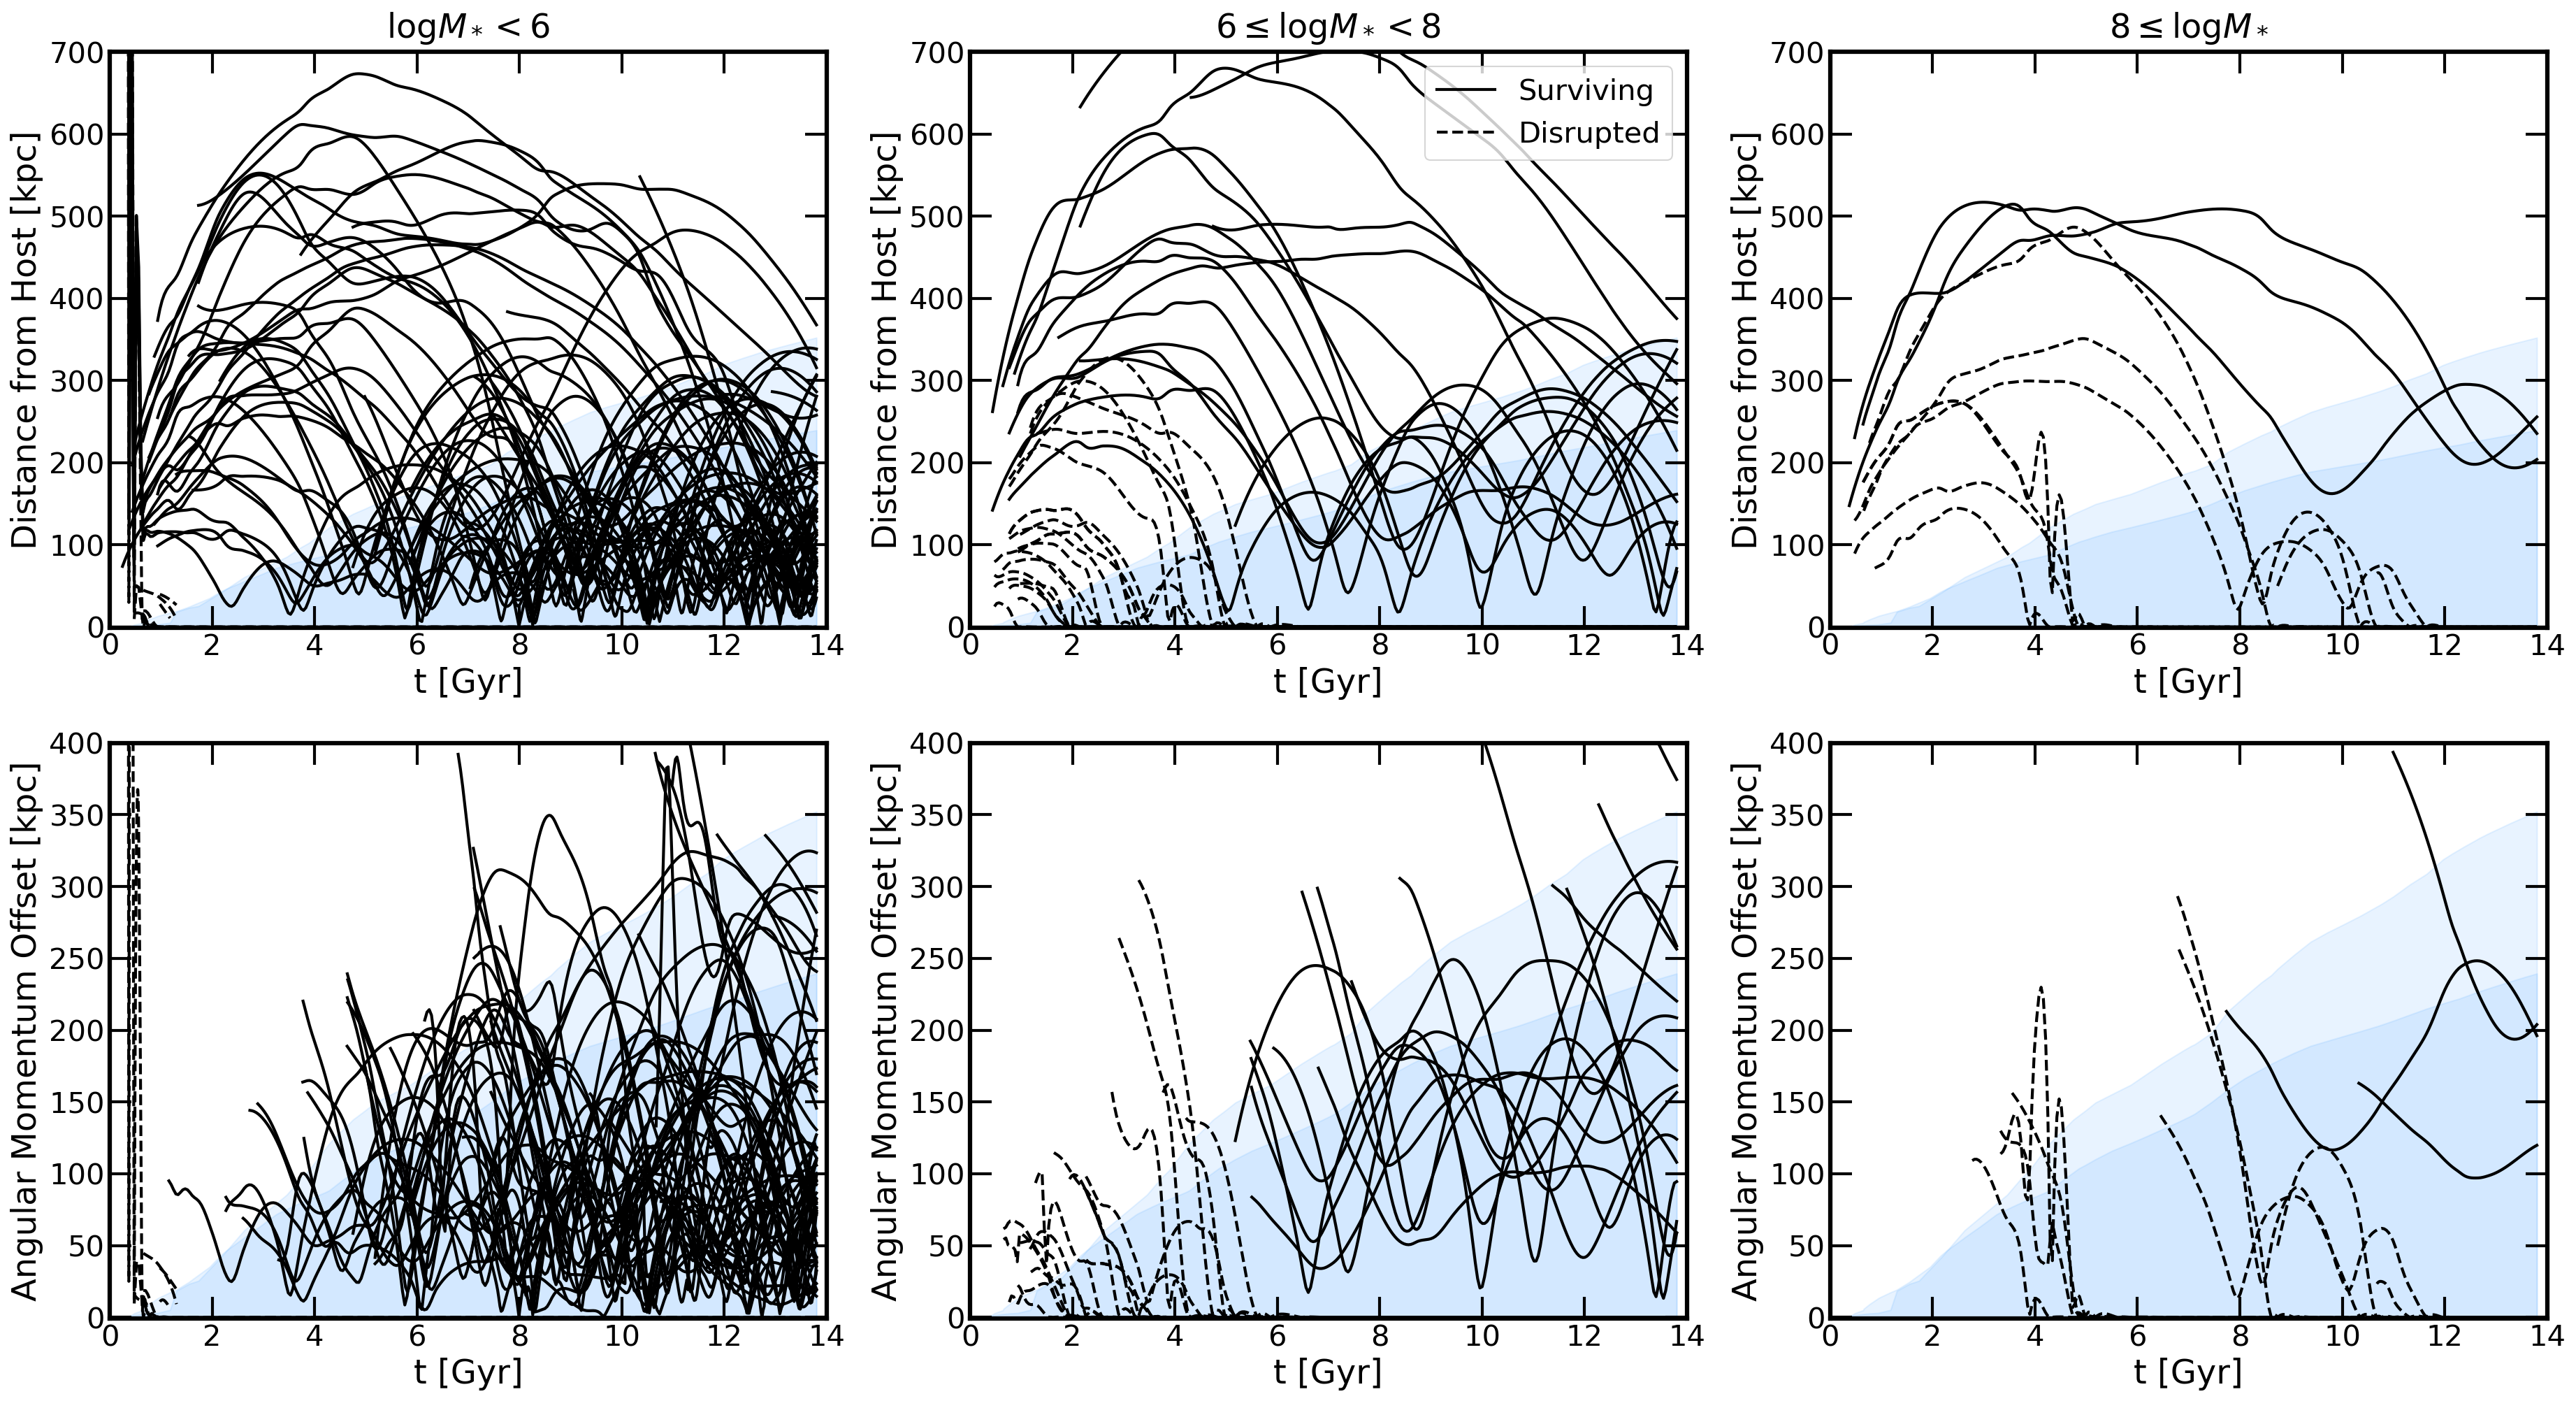

In [8]:
np.seterr(divide='ignore', invalid='ignore')
data = pd.read_csv('Data100_mint.csv')
status = data['Status'].to_numpy()
ids = data['ID'].to_numpy()
infall_Mstar = data['infall_mass'].to_numpy()
t_infall = data['time_infall'].to_numpy()
t_disrupt = data['time_disruption'].to_numpy()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='none', sharey='none', figsize=(30, 16))
fig.set_facecolor('w')
fig.set_dpi(150)
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
plt.setp(ax3.spines.values(), linewidth=3)
plt.setp(ax4.spines.values(), linewidth=3)
plt.setp(ax5.spines.values(), linewidth=3)
plt.setp(ax6.spines.values(), linewidth=3)

for sim in ['h148', 'h329']:
    path = get_file_path(tangos_halo=0, simulation=sim, status='Host', halo_id='1', snap_num='4096', resolution='Mint')
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostRvir = fh['Rvir_|_kpc'][:]
    ax1.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax2.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax3.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax4.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax5.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
    ax6.fill_between(t_Gyr, hostRvir, color='dodgerblue', alpha=0.1, lw=1)
count=0    
for idx in ids[(status=='Survivor')]:
    k, (t, x, y, z, Rvir) = orbit_interpolation(ID=idx, resolution='Mint')
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    
    R = (x**2 + y**2 + z**2)**(1/2)
    z_offset, t_Gyr = velocity_angles(ID=idx, interpolate=True, resolution='Mint')    

    if np.log10(infall_Mstar[ids==idx])<6:
        ax1.plot(t, R, lw=2, alpha=1, c='k')
#         ax4.plot(t_Gyr, z_offset, lw=0.5, alpha=0.8, c='k')
        ax4.plot(t_Gyr[(t_Gyr>=t_infall[ids==idx]-1)], z_offset[(t_Gyr>=t_infall[ids==idx]-1)], lw=2, alpha=1, c='k')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        if count==0:
            ax2.plot(t, R, lw=2, alpha=1, c='k', label='Surviving')
            count+=1
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='k')
#             ax5.plot(t_Gyr, z_offset, lw=0.5, alpha=0.8, c='k')
            ax5.plot(t_Gyr[(t_Gyr>=t_infall[ids==idx]-1)], z_offset[(t_Gyr>=t_infall[ids==idx]-1)], lw=2, alpha=1, c='k')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax3.plot(t, R, lw=2, alpha=1, c='k')
#         ax6.plot(t_Gyr, z_offset, lw=0.5, alpha=0.8, c='k')
        ax6.plot(t_Gyr[(t_Gyr>=t_infall[ids==idx]-1)], z_offset[(t_Gyr>=t_infall[ids==idx]-1)], lw=2, alpha=1, c='k')

# [(t_Gyr>=t_infall[ids==idx]) & (z_offset<=300)]
count=0
for idx in ids[(status=='Zombie')]:
    k, (t, x, y, z, Rvir) = orbit_interpolation(ID=idx, resolution='Mint')
    t=np.array(t)
    x=np.array(x)
    y=np.array(y)
    z=np.array(z)
    R = (x**2 + y**2 + z**2)**(1/2)

    z_offset, t_Gyr = velocity_angles(ID=idx, interpolate=True, resolution='Mint')
    if np.log10(infall_Mstar[ids==idx])<6:
        ax1.plot(t, R, lw=2, alpha=1, c='k', ls='--')
        ax4.plot(t_Gyr[(t_Gyr>=t_infall[ids==idx]-1)], z_offset[(t_Gyr>=t_infall[ids==idx]-1)], lw=2, alpha=1, c='k', ls='--')
    elif np.log10(infall_Mstar[ids==idx])>=6 and np.log10(infall_Mstar[ids==idx])<8:
        if count==0:
            ax2.plot(t, R, lw=2, alpha=1, c='k', ls='--', label='Disrupted')
            count+=1
        else:
            ax2.plot(t, R, lw=2, alpha=1, c='k', ls='--')
            ax5.plot(t_Gyr[(t_Gyr>=t_infall[ids==idx]-1)], z_offset[(t_Gyr>=t_infall[ids==idx]-1)], lw=2, alpha=1, c='k', ls='--')
    elif np.log10(infall_Mstar[ids==idx])>=8:
        ax3.plot(t, R, lw=2, alpha=1, c='k', ls='--')
        ax6.plot(t_Gyr[(t_Gyr>=t_infall[ids==idx]-1)], z_offset[(t_Gyr>=t_infall[ids==idx]-1)], lw=2, alpha=1, c='k', ls='--')
# [(z_offset<=300)]
ax1.set_xlim(0, 14)
ax1.set_ylim(-1, 700)

# ax1.set_xscale('log')
# ax1.legend(loc='best', fontsize=15, frameon=True)
ax1.tick_params(which='major', length=15, width=2, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax1.set_title('$\log M_* < 6$', fontsize=23, pad=10)
ax1.set_xlabel('t [Gyr]', fontsize=23)
ax1.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax2.set_xlim(0, 14)
ax2.set_ylim(-1, 700)
# ax1.set_xscale('log')
ax2.legend(loc='upper right', fontsize=20, frameon=True)
ax2.tick_params(which='major', length=15, width=2, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax2.set_title('$6 \leq \log M_* < 8$', fontsize=23, pad=10)
ax2.set_xlabel('t [Gyr]', fontsize=23)
ax2.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax3.set_xlim(0, 14)
ax3.set_ylim(-1, 700)
# ax1.set_xscale('log')
# ax1.legend(loc='best', fontsize=15, frameon=True)
ax3.tick_params(which='major', length=15, width=2, labelsize=15)
ax3.tick_params(which='minor', length=8, width=2, labelsize=15)
ax3.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax3.set_title('$8 \leq \log M_*$', fontsize=23, pad=10)
ax3.set_xlabel('t [Gyr]', fontsize=23)
ax3.set_ylabel('Distance from Host [kpc]', fontsize=23)

ax4.set_xlim(0, 14)
ax4.set_ylim(-1, 400)
ax4.tick_params(which='major', length=15, width=2, labelsize=15)
ax4.tick_params(which='minor', length=8, width=2, labelsize=15)
ax4.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax4.set_xlabel('t [Gyr]', fontsize=23)
ax4.set_ylabel('Angular Momentum Offset [kpc]', fontsize=23)

ax5.set_xlim(0, 14)
ax5.set_ylim(-1, 400)
ax5.tick_params(which='major', length=15, width=2, labelsize=15)
ax5.tick_params(which='minor', length=8, width=2, labelsize=15)
ax5.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax5.set_xlabel('t [Gyr]', fontsize=23)
ax5.set_ylabel('Angular Momentum Offset [kpc]', fontsize=23)

ax6.set_xlim(0, 14)
ax6.set_ylim(-1, 400)
ax6.tick_params(which='major', length=15, width=2, labelsize=15)
ax6.tick_params(which='minor', length=8, width=2, labelsize=15)
ax6.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
ax6.set_xlabel('t [Gyr]', fontsize=23)
ax6.set_ylabel('Angular Momentum Offset [kpc]', fontsize=23)